In [123]:
from itertools import chain
import pandas as pd
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
def read_data():
    
    data = pd.read_csv("dataframe.csv")
    data["dependencies"].fillna("", inplace=True)
    data["relevant_dependencies"].fillna("", inplace=True)
    data["dependencies"] = data["dependencies"].apply(lambda x: x.split("),"))
    data["relevant_dependencies"] = data["relevant_dependencies"].apply(lambda x: x.split("),"))
    data.drop('recommended_exclusion', axis=1, inplace=True)
    data.drop('sentence_id', axis=1, inplace=True)
    
    return data

#fixes some bad rows and seperates data into train and test - note the seperation is not random, it should be.
#dependency collumns are split into rough lists for future
data = read_data()

def process_data(data):
    dataset = []
    feature_set = []
    for i, (position, word, gerund, tags, dependencies, relDependencies, sentence) in data.iterrows():
        feature_set.append(gerund)
        feature_set.append(word)    
        deps = []
        for dependency in relDependencies:
            if len(dependency.split())<3:
                continue
            id = dependency.split()[0]
            w1 = dependency.split()[1][1:-1].split("-")[0]
            p1 = dependency.split()[1][1:-1].split("-")[1]
            w2 = dependency.split()[2].split("-")[0]
            p2 = dependency.split()[2].split("-")[1]
            organized_dependency = (id, w1, p1, w2, p2)
            deps.append(organized_dependency)
        feature_set.append(deps)
        feature_set.append(sentence)
        dataset.append(feature_set)
        feature_set = []
    return dataset

p_data = pd.DataFrame(process_data(data))

In [124]:
p_data.columns = ['type', 'gerund', 'rel_deps', 'sentence']

In [125]:
def count(dep, x):
    sum = 0
    for t in x:
        if t[0] == dep:
            sum += 1
    return sum

def countGerund(dep, x):
    sum = 0
    for t in x:
        if t[0] == dep and (t[1].endswith('ing') or t[3].endswith('ing')):
            sum += 1
    return sum

def countCC(x):
    return count('cc', x)
def countConj(x):
    return count('conj', x)
def countPunct(x):
    return count('punct', x)

def countGerundCC(x):
    return countGerund('cc', x)
def countGerundConj(x):
    return countGerund('conj', x)
def countGerundPunct(x):
    return countGerund('punct', x)


In [126]:
p_data['num_cc'] = p_data['rel_deps'].apply(countCC)
p_data['num_conj'] = p_data['rel_deps'].apply(countConj)
p_data['num_punct'] = p_data['rel_deps'].apply(countPunct)
p_data['num_gerund_cc'] = p_data['rel_deps'].apply(countGerundCC)
p_data['num_gerund_conj'] = p_data['rel_deps'].apply(countGerundConj)
p_data['num_gerund_punct'] = p_data['rel_deps'].apply(countGerundPunct)

In [127]:
p_data

,type,gerund,rel_deps,sentence,num_cc,num_conj,num_punct,num_gerund_cc,num_gerund_conj,num_gerund_punct
0,vp-ing,hearing,"[(xcomp, hearing, 5, remember, 4), (obj, phras...","I do n't remember hearing the phrase "" white g...",0,0,0,0,0,0
1,vp-ing,Growing,"[(advcl, Growing, 1, had, 10), (compound:prt, ...","Growing up black in the 1950s , I never had th...",0,0,0,0,0,0
2,vp-ing,having,"[(conj, irritability, 17, see, 3), (mark, at, ...","I can see now that possibly she was , but then...",0,1,0,0,0,0
3,vp-ing,feeling,"[(xcomp, feeling, 4, remember, 3), (obj, sympa...",I can remember feeling a certain sympathy for ...,0,0,0,0,0,0
4,vp-ing,drawing,"[(advcl, victimizing, 16, feeling, 4), (mark, ...",I can remember feeling a certain sympathy for ...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
55054,vp-ing,restraining,"[(mark, for, 5, restraining, 6), (acl, restrai...",The main government tools for restraining both...,0,0,0,0,0,0
55055,vp-ing,restraining,"[(mark, In, 1, restraining, 2), (advcl, restra...","In restraining such growth , allocation by pri...",0,0,0,0,0,0
55056,vp-ing,learning,"[(obl, negotiations, 8, allow, 5), (punct, ,, ...","Therefore , change must allow for complex nego...",0,1,1,0,1,1
55057,vp-ing,creating,"[(mark, of, 7, creating, 8), (advcl, creating,...","Political wisdom , therefore , consists of cre...",0,0,0,0,0,0


In [128]:
p_data['type'].value_counts(normalize=True)

vp-ing         0.756643
acc-ing        0.108139
ing-of         0.054160
det-ing        0.053742
poss-ing       0.022685
poss-ing-of    0.004631
Name: type, dtype: float64

In [129]:
p_data[p_data['num_cc'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.865684
ing-of         0.057593
acc-ing        0.038661
det-ing        0.023715
poss-ing       0.010562
poss-ing-of    0.003786
Name: type, dtype: float64

In [130]:
p_data[p_data['num_conj'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.804588
acc-ing        0.078047
ing-of         0.049941
det-ing        0.042564
poss-ing       0.020729
poss-ing-of    0.004131
Name: type, dtype: float64

In [131]:
p_data[p_data['num_punct'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.855252
ing-of         0.049371
acc-ing        0.047309
det-ing        0.035916
poss-ing       0.009983
poss-ing-of    0.002170
Name: type, dtype: float64

In [132]:
p_data[p_data['num_gerund_cc'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.880748
ing-of         0.051998
acc-ing        0.034809
det-ing        0.019768
poss-ing       0.008595
poss-ing-of    0.004083
Name: type, dtype: float64

In [133]:
p_data[p_data['num_gerund_conj'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.833333
acc-ing        0.066607
ing-of         0.048277
det-ing        0.033754
poss-ing       0.014123
poss-ing-of    0.003906
Name: type, dtype: float64

In [134]:
p_data[p_data['num_gerund_punct'] > 0]['type'].value_counts(normalize=True)

vp-ing         0.867680
ing-of         0.045506
acc-ing        0.043804
det-ing        0.033023
poss-ing       0.007717
poss-ing-of    0.002270
Name: type, dtype: float64

<AxesSubplot:>

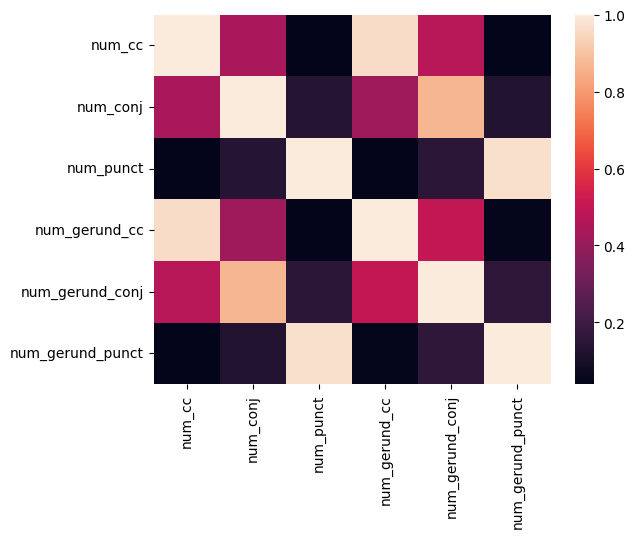

In [135]:
sns.heatmap(p_data.corr())

In [136]:
p_data[(p_data['num_gerund_cc'] > 0) & (p_data['num_gerund_conj'] > 0) & (p_data['num_gerund_punct'] > 0)]['sentence'].iloc[0]

'It is obvious that this was a rather shameful encounter for all concerned -- my friend and I , as his silent accomplice , trading on our racial pain , tampering with a stranger for no reason , and the stranger then buying his way out of the situation for twenty dollars , a sum that was generous by one count and cheap by another .'

In [137]:
from xml.dom.minidom import parse, Node

def set_id_attribute(parent, attribute_name="id"):
    if parent.nodeType == Node.ELEMENT_NODE:
        if parent.hasAttribute(attribute_name):
            parent.setIdAttribute(attribute_name)
    for child in parent.childNodes:
        set_id_attribute(child, attribute_name)

def remove_whitespace(node):
    if node.nodeType == Node.TEXT_NODE:
        if node.nodeValue.strip() == "":
            node.nodeValue = ""
    for child in node.childNodes:
        remove_whitespace(child)

document = parse("en_dimlex.xml")
set_id_attribute(document)
remove_whitespace(document)
document.normalize()

conns = []
for id in range(1,143):
    e = document.getElementById(str(id))
    word = e.getAttribute('word')
    syns = {}
    for syn in e.getElementsByTagName("syn"):
        cat = syn.firstChild.firstChild.nodeValue
        syns['cat'] = cat
        sems = []
        for sem in syn.getElementsByTagName("sem"):
            sense = sem.firstChild.getAttribute('sense')
            pdtb_freq = sem.firstChild.getAttribute('pdtb_freq')
            s = {'sense': sense, 'pdtb_freq': pdtb_freq}
            sems.append(s)
        syns['sems'] = sems
    modifiers = []
    for pdtb_m in e.getElementsByTagName("pdtb_modifiers"):
        for mod in pdtb_m.getElementsByTagName("modifier"):
            modifier = mod.firstChild.nodeValue
            modifiers.append(modifier)
    conns.append({'word': word, 'syns': syns, 'modifiers': modifiers})

connectives = pd.DataFrame(conns)

In [138]:
# connectives = {'additive': ['moreover', 'further', 'also', 'furthermore'],
# 'causal': ['because', 'hence', 'therefore', 'since'],
# 'temporal': [ 'before', 'next', 'finally', 'after'],
# 'adversative': ['however', 'although', 'in contrast', 'alternatively']}

# for index, row in p_data.iterrows():
#     for type in connectives.keys():
#         for word in connectives[type]:
#             p_data.loc[index, word] = findDepWithWord(row, word)

# for index, row in p_data.iterrows():
#     for type in connectives.keys():
#         p_data.loc[index, type] = ''
#         for word in connectives[type]:
#             dep = findDepWithWord(row, word)
#             if dep != '':
#                 p_data.loc[index, type] = dep

In [139]:
def findDepWithWord(row, kwargs):
    word = kwargs[0]
    for t in row['rel_deps']:
        if t[1] == word and t[3] == row['gerund'] or t[3] == word and t[1] == row['gerund']:
            return t[0]
    return ''

In [140]:
connectives['word'].iloc[:10]

0            once
1        although
2          though
3             but
4         because
5    nevertheless
6          before
7     for example
8           until
9              if
Name: word, dtype: object

In [141]:
for word in connectives['word']:
    p_data[word] = p_data.apply(findDepWithWord, kwargs=[word], axis=1)

In [142]:
p_data[p_data['although'] != '']['although']

1823     mark
6619     mark
12539    mark
29443    mark
29651    mark
30590    mark
37627    mark
38690    mark
42484    mark
42615    mark
Name: although, dtype: object

In [143]:
# p_data[p_data['temporal'] != '']['temporal']

In [156]:
cols = list(p_data['type'].unique())
cols.insert(0, 'word')
cols.append('total_count')
conn_stats = pd.DataFrame(columns=cols)
for word in connectives['word']:
    rows = p_data[p_data[word] != '']
    val_counts = rows['type'].value_counts()
    counts = [word]
    for t in cols[1:7]:
        if t in val_counts.index:
            counts.append(val_counts[t])
        else:
            counts.append(0)
    counts.append(np.sum(counts[1:]))
    conn_stats.loc[len(conn_stats.index)] = counts

In [180]:
common_words = conn_stats[conn_stats['total_count'] >= 100]

In [174]:
rates = conn_stats[conn_stats['total_count'] >= 100][p_data['type'].unique()].div(conn_stats[conn_stats['total_count'] >= 100]['total_count'], axis=0)

In [175]:
rates.columns

Index(['vp-ing', 'ing-of', 'poss-ing', 'acc-ing', 'det-ing', 'poss-ing-of'], dtype='object')

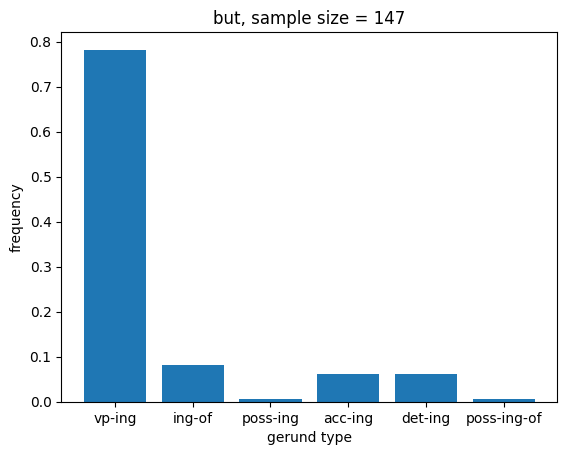

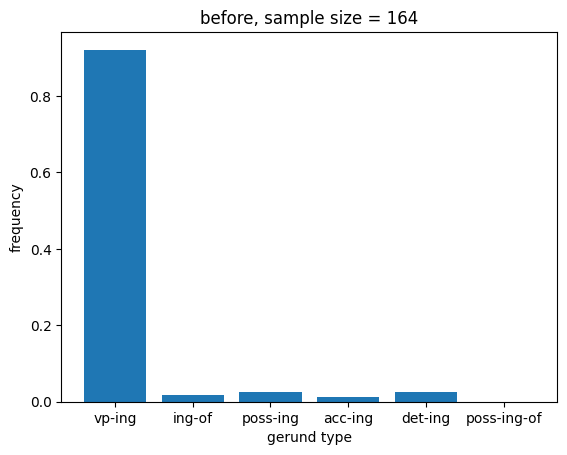

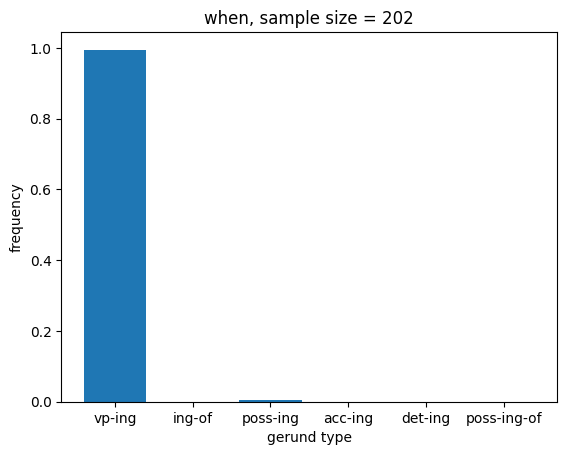

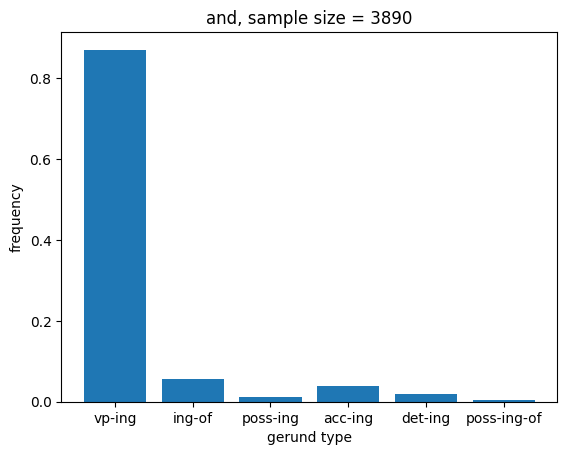

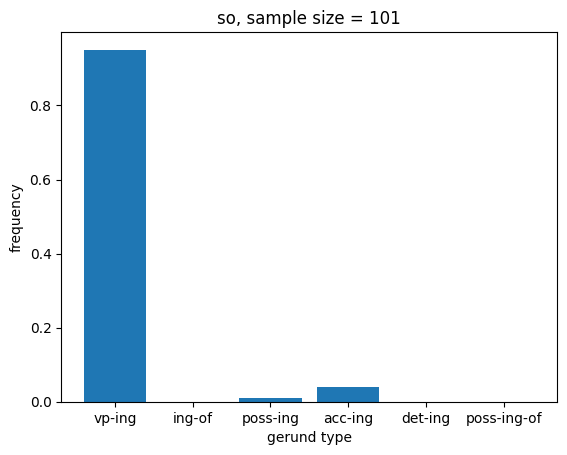

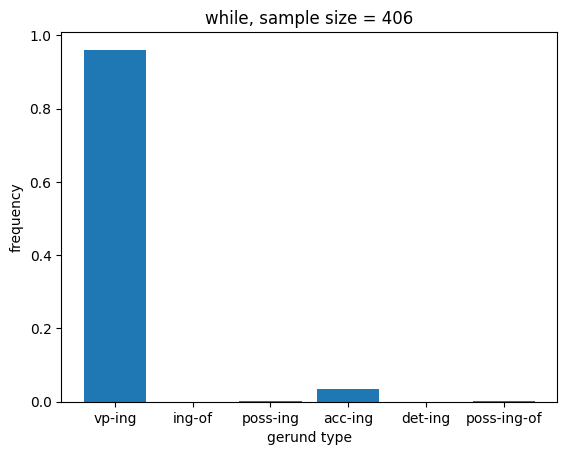

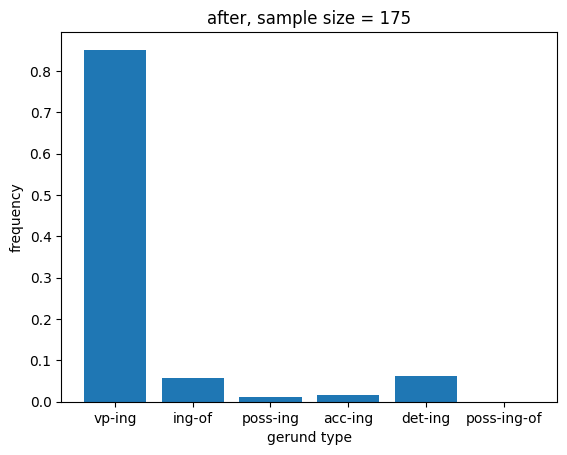

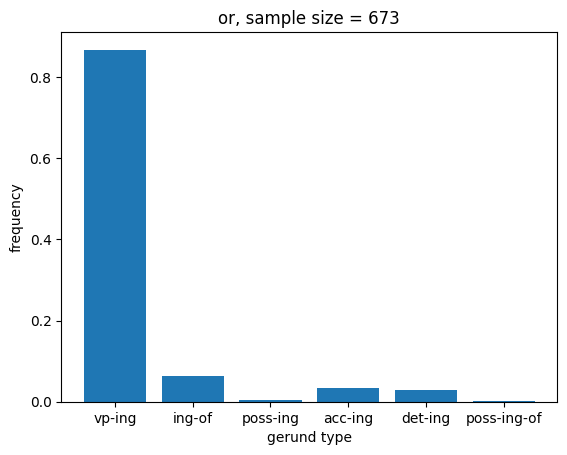

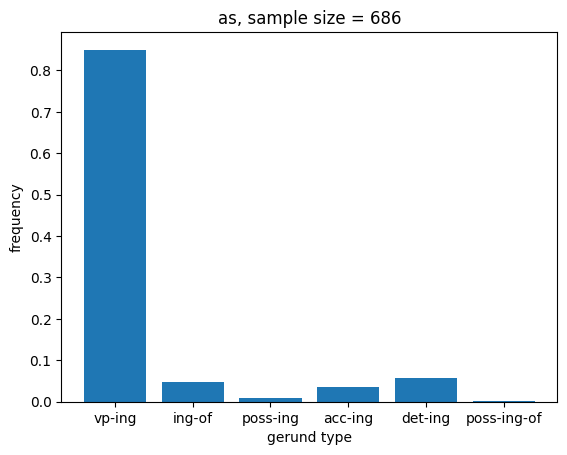

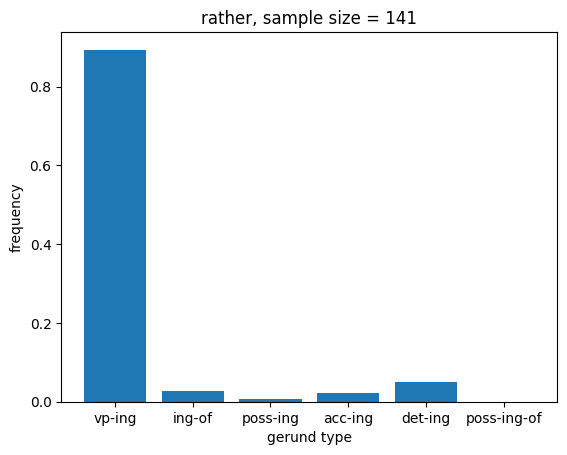

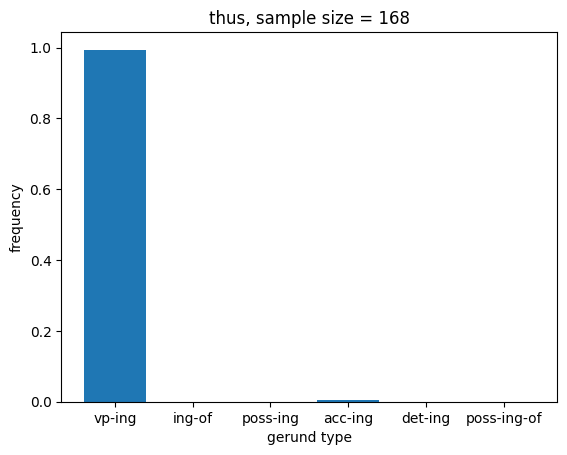

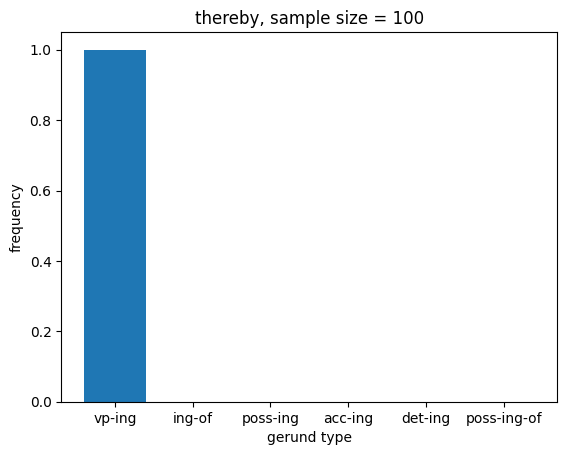

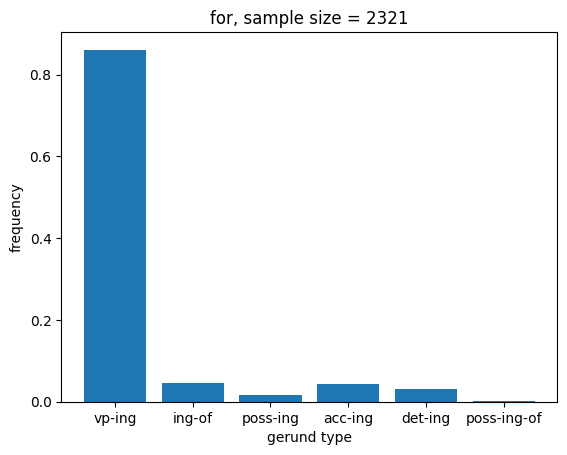

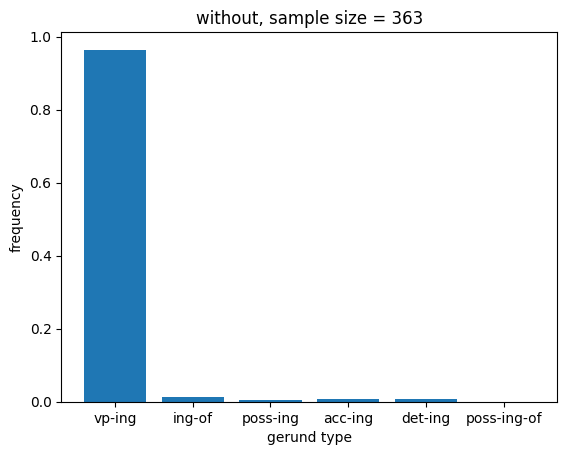

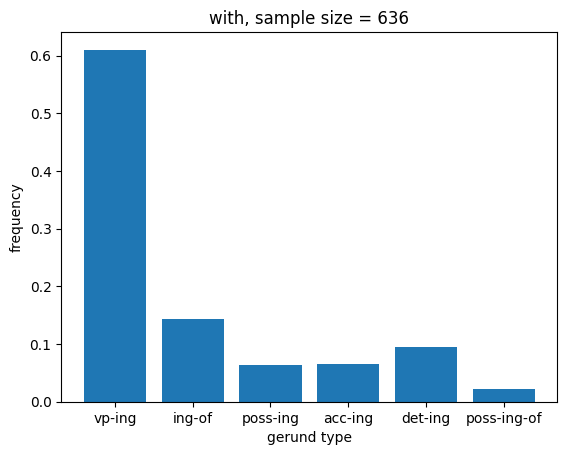

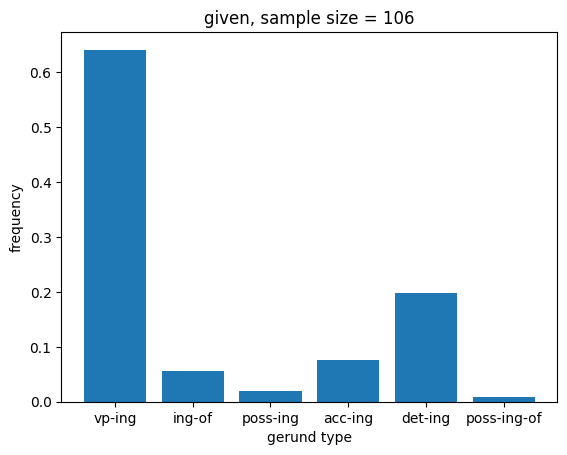

In [182]:
i = 0
for word in common_words['word']:
    plt.figure()
    plt.bar(rates.columns, rates.iloc[i])
    plt.title(word + ", sample size = " + str(common_words['total_count'].iloc[i]))
    plt.xlabel('gerund type')
    plt.ylabel('frequency')
    i += 1